# PRÁCTICA 11: Redes Neuronales de Funciones de Base Radial (RBF) y Máquinas de Vectores Soporte (SVM)

#### TAA - 8 JUNIO
#### MIGUEL CHAVEINTE GARCÍA

In [32]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score as ac

from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.svm import SVC

import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt
import pandas as pd

In [33]:
data = load_breast_cancer()

In [34]:
# Normalizar
X = MinMaxScaler().fit_transform(data.data)
y = data.target

X.shape, y.shape

((569, 30), (569,))


#### ACIERTO PARA CADA NEURONA DE CAPA OCULTA

In [20]:
# Creación de 10 particiones para realizar validación cruzada
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

    N º Clusters  Tasa de acierto
0            2.0         0.927882
1            3.0         0.899781
2            4.0         0.901598
3            5.0         0.926159
4            6.0         0.901535
5            7.0         0.912061
6            8.0         0.912124
7            9.0         0.931485
8           10.0         0.929731
9           11.0         0.931485
10          12.0         0.924405
11          13.0         0.934962
12          14.0         0.936717
13          15.0         0.934962
14          16.0         0.926159
15          17.0         0.934962
16          18.0         0.945520
17          19.0         0.938503
18          20.0         0.940288
19          21.0         0.940288
20          22.0         0.957801
21          23.0         0.961278
22          24.0         0.948997
23          25.0         0.957832
24          26.0         0.956078
25          27.0         0.950783
26          28.0         0.952538
27          29.0         0.938534
28          30

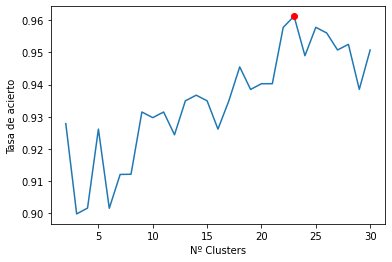

In [23]:
# Array que almacenará el número de clusters con el que obtuvimos la mayor tasa de acierto para
# tamaño de capa oculta varia de 2 a 30
min_hl_size = 2
max_hl_size = 30
# Array para almacenar los resultados de la tasa de acierto por tamaño de capa oculta
hl_accuracy = np.zeros(max_hl_size-1, dtype='float')

#dataframe para sacar la tasa de acierto por cada clusters
df = pd.DataFrame( columns = ['N º Clusters' , 'Tasa de acierto'])

for hl in range(min_hl_size,max_hl_size+1):
    # Creación del agrupamiento de kmedias con un número de clusters igual al número de neuronas que varia de 2 a 30
    kmeans = KMeans(n_clusters=hl, random_state=0)
    
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Entrenamiento de kmeans en la partición
        kmeans.fit(X_train)
        # Array para almacenar el etiquedado de moda de los clusters existentes en cada partición
        mode_fold = np.ones(hl, dtype='int')
        
        for c in range(hl):
            # Número de clusters como número de neuronas
            cluster_labels = kmeans.labels_
            # Moda para cada cluster
            mode_fold[c] = mode(y_train[np.argwhere(cluster_labels == c)])[0]
        
        # Predecimos el cluster al que van a pertenecer las instancias de prueba
        cluster_predict = kmeans.predict(X_test)
        # Etiquetamos cada instancia con la moda del cluster al que pertenecen
        y_test_predict = mode_fold[cluster_predict]
        
        # Suma de las 10 tasas de acierto para cada cluster
        hl_accuracy[hl-min_hl_size] += ac(y_test,y_test_predict)
    
    # Media de la tasa de aciertos para cada número de clusters
    hl_accuracy[hl-min_hl_size] /= 10
    
        
    df.loc[hl-2]=[ hl, hl_accuracy[hl-min_hl_size] ]


print(df)
y_plot = hl_accuracy
x_plot = [i+min_hl_size for i in range(y_plot.shape[0])]
plt.plot(x_plot,y_plot)
plt.plot(np.argmax(y_plot)+min_hl_size,y_plot[np.argmax(y_plot)],marker="o",color="r")
plt.xlabel("Nº Clusters")
plt.ylabel("Tasa de acierto")
plt.show()

In [22]:
optimal_cluster = np.argmax(hl_accuracy)+min_hl_size

print("La mayor tasa de acierto la obtenemos con",optimal_cluster,"clusters" %hl_accuracy[np.argmax(hl_accuracy)])

La mayor tasa de acierto la obtenemos con 2 clusters


#### RBF CON SVM EN LA CAPA DE SALIDA CON FUNCIÓN DE NÚCLEO POLINÓMICA

In [48]:
min_degree = 1
max_degree = 5
# Array para almacenar los resultados de la tasa de acierto por cada posible grado de función polinómica
accuracy_per_degree = np.zeros(max_degree, dtype='float')

#dataframe para sacar la tasa de acierto por cada clusters
df1 = pd.DataFrame( columns = ['Grado polinomial' , 'Tasa de acierto'])
for degree in range(min_degree, max_degree+1):
    
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Creación del agrupamiento de kmedias con el número de clusters óptimo anteriormente calculado
        kmeans = KMeans(n_clusters=optimal_cluster, random_state=0)
        # Entrenamiento de kmeans en la partición
        kmeans.fit(X_train)
        # Cálculo de los centros de cada cluster
        centers = kmeans.cluster_centers_
        
        # Cálculo de las distancias entre los centros de los clusters y del parámetro sigma
        distances = euclidean_distances(centers)
        sigma = np.sum(distances, axis=0)/(centers.shape[0]-1)
        
        # Matriz que almacena los grados de pertenencia de cada instancia de prueba a cada cluster
        X_rbf_train = np.zeros((X_train.shape[0], centers.shape[0]), dtype='float')
        for i in range(X_train.shape[0]):
            for j in range(centers.shape[0]):
                # Cálculo de la función de base radial para el conjunto de entrenamiento
                X_rbf_train[i][j] = np.exp(-np.sum((X_train[i]-centers[j])**2)/(2.0*(sigma[j]**2)))
        
        # Matriz que almacena los grados de pertenencia de cada instancia de test a cada cluster
        X_rbf_test = np.zeros((X_test.shape[0], centers.shape[0]), dtype='float')
        for i in range(X_test.shape[0]):
            for j in range(centers.shape[0]):
                # Cálculo de la función de base radial para el conjunto de prueba
                X_rbf_test[i][j] = np.exp(-np.sum((X_test[i]-centers[j])**2)/(2.0*(sigma[j]**2)))
        
        # Creamos y entrenamos el separador basado en máquinas de vectores soporte con función de núcleo polinómica
        svm = SVC(kernel='poly', degree=degree, random_state=0, gamma='auto')
        svm.fit(X_rbf_train,y_train)
        
        # Calculamos la tasa de acierto para la salida de la capa oculta para el conjunto de entrenamiento
        accuracy = svm.score(X_rbf_test,y_test)
        accuracy_per_degree[degree-min_degree] += accuracy
    
    # Media de la tasa de aciertos para cada grado de polinomio
    accuracy_per_degree[degree-min_degree] /=10
    df1.loc[degree-1]=[ degree, accuracy_per_degree[degree-min_degree] ]

print(df1)


   Grado polinomial  Tasa de acierto
0               1.0         0.938471
1               2.0         0.931422
2               3.0         0.926159
3               4.0         0.920896
4               5.0         0.915633


In [51]:
optimal_degree = np.argmax(accuracy_per_degree)+min_degree   

print("La mayor tasa de acierto la obtenemos con un kernel polinómico de grado",optimal_degree,"-" ,accuracy_per_degree[np.argmax(accuracy_per_degree)])

La mayor tasa de acierto la obtenemos con un kernel polinómico de grado 1 - 0.9384711779448622
